In [1]:
using SparseArrays, LinearAlgebra, IndexedGraphs
using Causality
using Plots
using JLD2

# Generation of Epidemics

In [2]:
T = 20 
N = 904
out = load("./SimulatedGraphs/Tubingen_seed1.jld2")
V = [MaskedRate(UnitRate(),v) for v in  out["V"]]
G = out["G"]
xeff = out["states"]
xtrue = T .* ones(N)
for i = 1:N
    for t = 1:T
        if xeff[t][i] > 10
            xtrue[i] = t-1
            break
        end
    end
end
nobs, p = 10, 1e-5 #p is mute
O = [(ti = T*(1+rand())/2; (i,xtrue[i] < ti,24 * ti,p)) for i=1:nobs]

10-element Vector{Tuple{Int64, Bool, Float64, Float64}}:
 (1, 0, 393.9067468260596, 1.0e-5)
 (2, 0, 308.93763560626434, 1.0e-5)
 (3, 0, 408.05893853722796, 1.0e-5)
 (4, 1, 461.7401423400805, 1.0e-5)
 (5, 0, 402.5525163186371, 1.0e-5)
 (6, 0, 383.9542156456879, 1.0e-5)
 (7, 0, 368.8674942811363, 1.0e-5)
 (8, 1, 351.4470442570488, 1.0e-5)
 (9, 1, 445.2045598384914, 1.0e-5)
 (10, 0, 348.18574861365926, 1.0e-5)

In [3]:
getpar(pseed,autoinf::GaussianRate,inf_in::GaussianRate) = 
    [fill(pseed, 1, N);
     fill(autoinf.a, 1, N); fill(autoinf.b, 1, N); fill(autoinf.c, 1, N);
     fill(inf_in.a,   1, N); fill(inf_in.b, 1, N); fill(inf_in.c, 1, N);
    ]

getpargen(pseed, autoinf::GaussianRate, inf_out::GaussianRate) = 
    [pseed autoinf.a autoinf.b autoinf.c inf_out.a inf_out.b inf_out.c]


getpargen (generic function with 1 method)

In [9]:
#Initialize generation parameters
T = 20 * 24
ε = 1e-10
λ = 0.4 / 24
pseed = 20/N
autoinf = GaussianRate(ε, T/2, 1/ε)
inf_in = GaussianRate(1.0, T/2, 1/ε)
inf_out = GaussianRate(λ, T/2, 1/ε)

θp = getpar(pseed, autoinf, inf_in);
θpgen = getpargen(pseed, autoinf, inf_out);

In [10]:
#Initialize min/max boundaies
T = Float64(T)
pseed_min = ε
pseed_max = 1-ε
rate_min = GaussianRate(ε  ,  -T,   ε)
rate_max = GaussianRate(1/ε  ,  2T,   1/ε)

inf_min = GaussianRate(ε  ,  -T,   ε)
inf_max = GaussianRate(1/ε  ,  2T, 1. )

θmin = getpar(pseed_min , rate_min, rate_min);
θmax = getpar(pseed_max , rate_max, rate_max);

rate_min = GaussianRate(ε  ,  -T,   ε)
rate_max = GaussianRate(1/ε  ,  T,   T)

θgenmin = getpargen(pseed_min, rate_min, rate_min);
θgenmax = getpargen(pseed_max, rate_max, rate_max);

In [11]:
const Igen = GenerativeSI{GaussianRate,GaussianRate} 
const Igauss = GaussianInferentialSI

GaussianInferentialSI

0.07411504424778761


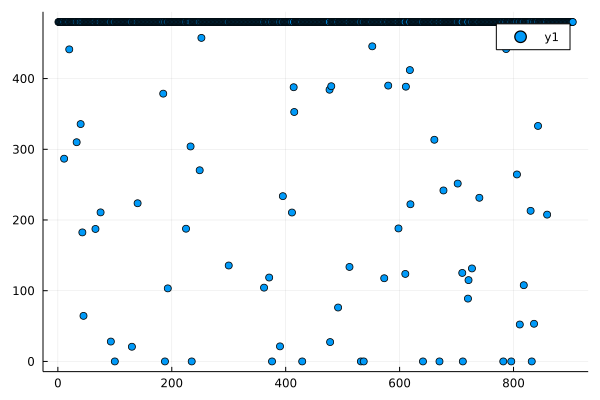

In [26]:
#Questo ci serve a verificare che i parametri siano giusti

Mp = StochasticModel(Igen, T, θp, G, θpgen, V);
sample! = Sampler(Mp);
xtrue = zeros(N)
ni = 0
sample!(xtrue)
println(sum(xtrue .< T)/N)
scatter(xtrue)

## Causality 

In [8]:
#Softened model
T = Float64(T)
ε = 2e-3
autoinf = GaussianRate(ε, T/2, T);
θp2gen = getpargen(pseed, autoinf, inf_out);
inf_in = GaussianRate(1., T/2, 3*T );

θp2 = getpar(pseed, autoinf, inf_in);
Mp2 = StochasticModel(Igen, T, θp2, G, θp2gen, V);

In [124]:
θ = getpar(pseed, autoinf, inf_in);
autoinf = GaussianRate(1., T/2, T);
M = StochasticModel(Igauss, T, θ, G, θp2gen, V);

In [125]:
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear)
F = descend!(Mp2, O; M=M, numsamples=1000, numiters=10, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.1),
         hyperdescender=SignDescender(0.));
F = descend!(Mp2, O; M=M, numsamples=1000, numiters=10, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.03),
         hyperdescender=SignDescender(0.));

LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
      [1] [0m[1mreshape[22m
    [90m    @ [39m[90m./[39m[90m[4mreshapedarray.jl:51[24m[39m[90m [inlined][39m
      [2] [0m[1mreshape[22m
    [90m    @ [39m[90m./[39m[90m[4mreshapedarray.jl:111[24m[39m[90m [inlined][39m
      [3] [0m[1mreshape[22m
    [90m    @ [39m[90m./[39m[90m[4mreshapedarray.jl:141[24m[39m[90m [inlined][39m
      [4] [0m[1m_maybe_reshape_parent[22m
    [90m    @ [39m[90m./[39m[90m[4msubarray.jl:124[24m[39m[90m [inlined][39m
      [5] [0m[1mview[22m
    [90m    @ [39m[90m./[39m[90m[4msubarray.jl:178[24m[39m[90m [inlined][39m
      [6] [0m[1mmaybeview[22m
    [90m    @ [39m[90m./[39m[90m[4mviews.jl:146[24m[39m[90m [inlined][39m
      [7] [0m[1mindividual[22m[0m[1m([22m[90m#unused#[39m::[0mType[90m{GaussianInferentialSI}[39m, [90mθi[39m::[0mSubArray[90m{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}[39m, [90mθg[39m::[0mMatrix[90m{Float64}[39m[0m[1m)[22m
    [90m    @ [39m[35mCausality[39m [90m~/git/Causality/src/[39m[90m[4msi.jl:20[24m[39m
      [8] [0m[1mindividual[22m[90m (repeats 3 times)[39m
    [90m    @ [39m[90m~/git/Causality/src/[39m[90m[4mstochasticmodel.jl:51[24m[39m[90m [inlined][39m
      [9] [0m[1m(::Causality.var"#sample!#48"{StochasticModel{GaussianInferentialSI, IndexedBiDiGraph{Int64}, Vector{MaskedRate{UnitRate}}}, TrackingHeaps.TrackingHeap{Int64, Float64, 2, TrackingHeaps.MinHeapOrder, TrackingHeaps.NoTrainingWheels}, BitVector, Int64})[22m[0m[1m([22m[90mx[39m::[0mMatrix[90m{Float64}[39m[0m[1m)[22m
    [90m    @ [39m[35mCausality[39m [90m~/git/Causality/src/[39m[90m[4msi.jl:63[24m[39m
     [10] [0m[1mmacro expansion[22m
    [90m    @ [39m[90m~/git/Causality/src/[39m[90m[4mvariation.jl:61[24m[39m[90m [inlined][39m
     [11] [0m[1m(::Causality.var"#12#threadsfor_fun#32"{StochasticModel{GaussianInferentialSI, IndexedBiDiGraph{Int64}, Vector{MaskedRate{UnitRate}}}, Int64, StochasticModel{GenerativeSI{GaussianRate, GaussianRate}, IndexedBiDiGraph{Int64}, Vector{MaskedRate{UnitRate}}}, Vector{Tuple{Int64, Bool, Float64, Float64}}, Matrix{Float64}, Vector{Causality.var"#sample!#48"{StochasticModel{GaussianInferentialSI, IndexedBiDiGraph{Int64}, Vector{MaskedRate{UnitRate}}}, TrackingHeaps.TrackingHeap{Int64, Float64, 2, TrackingHeaps.MinHeapOrder, TrackingHeaps.NoTrainingWheels}, BitVector, Int64}}, Vector{Float64}, Vector{Matrix{Float64}}, Vector{Matrix{Float64}}, Vector{Matrix{Float64}}, Vector{Matrix{Float64}}, Vector{Matrix{Float64}}, Int64, Float64, UnitRange{Int64}})[22m[0m[1m([22m[90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @ [39m[35mCausality[39m [90m./[39m[90m[4mthreadingconstructs.jl:85[24m[39m
     [12] [0m[1m(::Causality.var"#12#threadsfor_fun#32"{StochasticModel{GaussianInferentialSI, IndexedBiDiGraph{Int64}, Vector{MaskedRate{UnitRate}}}, Int64, StochasticModel{GenerativeSI{GaussianRate, GaussianRate}, IndexedBiDiGraph{Int64}, Vector{MaskedRate{UnitRate}}}, Vector{Tuple{Int64, Bool, Float64, Float64}}, Matrix{Float64}, Vector{Causality.var"#sample!#48"{StochasticModel{GaussianInferentialSI, IndexedBiDiGraph{Int64}, Vector{MaskedRate{UnitRate}}}, TrackingHeaps.TrackingHeap{Int64, Float64, 2, TrackingHeaps.MinHeapOrder, TrackingHeaps.NoTrainingWheels}, BitVector, Int64}}, Vector{Float64}, Vector{Matrix{Float64}}, Vector{Matrix{Float64}}, Vector{Matrix{Float64}}, Vector{Matrix{Float64}}, Vector{Matrix{Float64}}, Int64, Float64, UnitRange{Int64}})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @ [39m[35mCausality[39m [90m./[39m[90m[4mthreadingconstructs.jl:52[24m[39m

In [87]:
statscau = prior(M, numsamples=1000);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


## SoftMarg

In [88]:
Osoft = [(o[1],o[2],o[3],max(0.05,f_rate)) for o in O]

4-element Vector{Tuple{Int64, Int64, Real, Float64}}:
 (1, 1, 0.01, 0.05)
 (2, 1, 0.01, 0.05)
 (3, 0, 0.01, 0.05)
 (3, 1, 5, 0.05)

In [89]:
stats, weights = softpostnoise(Mp, Osoft; numsamples=2 * 10);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


## Sib

In [90]:
using PyCall
@pyimport sib
function sibyl(N, T_cont, Λ, O, γ, λ ; dt=1/5, maxit = 400, tol = 1e-14)
    
    T = Int(round(T_cont / dt))
    contacts = [(i-1,j-1,t, λ * dt) for t in 1:T for (i,j,v) in zip(findnz(Λ.A)...)];
    obs = [[(i,-1,t) for t=1:T for i=0:N-1];
           [(i-1,s,Int(round(t/dt))) for (i,s,t,p) in O]]
    sort!(obs, lt=((i1,s1,t1),(i2,s2,t2))->(t1<t2))
    prob_sus = 0.5
    prob_seed=γ
    pseed = prob_seed / (2 - prob_seed)
    psus = prob_sus * (1 - pseed)
    params = sib.Params(prob_r=sib.Exponential(mu=0), pseed=pseed, psus=psus,pautoinf=1e-10,fp_rate=1e-10,fn_rate=1e-10)
    f = sib.FactorGraph(contacts=contacts, observations=obs, params=params)
    sib.iterate(f, maxit=maxit,tol=tol)
    sib.iterate(f, maxit=maxit, damping=0.5, tol=tol)
    sib.iterate(f, maxit=maxit, damping=0.9, tol=tol)
    p_sib=[collect(n.bt) for n in f.nodes]
    m_sib = zeros(N, T)
    for i=1:N
        m_sib[i,1] = p_sib[i][1] 
        for t=2:T
            m_sib[i,t] = m_sib[i,t-1] + p_sib[i][t]
        end
    end 
    return m_sib
end

sibyl (generic function with 1 method)

In [91]:
a=time()
dt = 1/20
p_sib = NonMarkovSibyl(N, T, G, O, pseed, λ; dt=dt, maxit = 40, tol = 1e-7);
b=time()
println(b-a)

sib.iterate(damp=0.0): 0/1 1.000e+00/1e-07      
sib.iterate(damp=0.5): 0/1 5.451e-01/1e-07      
3.3478500843048096.9): 0/1 3.571e-01/1e-07      



## Marginals and ROC curve

In [96]:
function marginal(i, t, stats)
    numsamp = size(stats,1)
    sum(stats[:,i] .< t)/numsamp
end

function reweighted_marginal(i, t, stats, weights)
    numsamp = size(stats,1)
    @assert numsamp == size(weights,1)
    weights ./= maximum(weights)
    sum(weights .* (stats[:,i] .< t))/sum(weights)
end

function tpr(xtrue, rank) 
    cumsum(xtrue[rank]) ./( cumsum(xtrue[rank])[end])
end

function fpr(xtrue, rank) 
    N = size(rank,1)
    return (range(1,N,length=N) .- cumsum(xtrue[rank])) ./ (range(1,N,length=N) .- cumsum(xtrue[rank]) )[end]
end

function ROC(xtrue, p)
    N = size(xtrue,1)
    rank = sortperm(p, rev=true)
    
    return fpr(xtrue, rank) , tpr(xtrue, rank)
end

function AUROC(ROC)
    N = size(ROC[1],1) 
    AU = 0
    for t = 1:N-1
        AU += ROC[2][t] * (ROC[1][t+1] - ROC[1][t])
    end
    return AU
end

AUROC (generic function with 1 method)

In [97]:
#Marginals
bins = 2 * Int(T)
using Plots
p_cau = zeros(N,bins)
p_soft = zeros(N,bins)
for i = 1:N
    for t = 1:bins
       p_cau[i,t] = marginal(i, t*T/bins, statscau)
       p_soft[i,t] = reweighted_marginal(i, t*T/bins, stats, weights)
    end
end

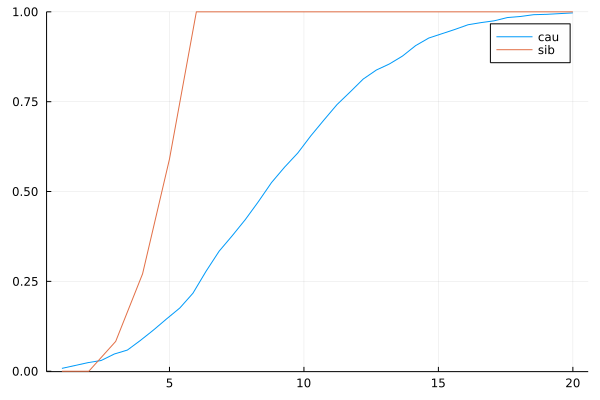

In [100]:
i = 3
plot(LinRange(1,Int(T),bins),p_cau[i,:], label = "cau")
plot!(LinRange(1,Int(T),bins),p_soft[i,:], label = "soft")
plot!(LinRange(1,Int(T),Int(round(T/dt))),p_sib[i,:], label = "sib")
ylims!(-0.001,1)

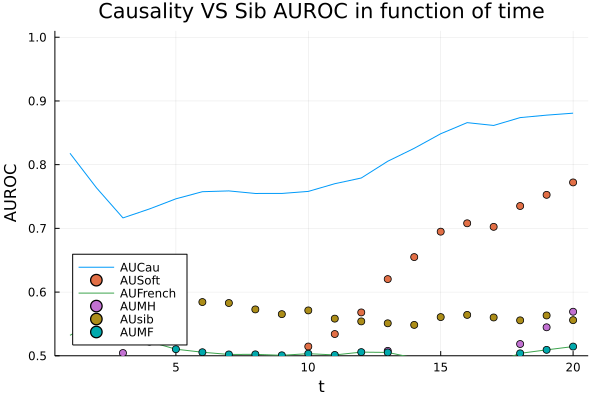

In [104]:
#AUROC curves
T = Int(T)
AU_curve=zeros(T)
AU_sib=zeros(T)
AU_soft = zeros(T)
for t = 1:T
    cau_risk=zeros(N)
    sib_risk = zeros(N)
    soft_risk = zeros(N)
    for i=1:N
       cau_risk[i] = marginal(i,t,statscau)
       sib_risk[i] = p_sib[i,Int(round(t/dt))]
       soft_risk[i] = reweighted_marginal(i, t*T/bins, stats, weights)
    end
    xt = xtrue .< t
    AU_soft[t] = AUROC(ROC(xt, soft_risk))
    AU_curve[t] = AUROC(ROC(xt, cau_risk))
    AU_sib[t] = AUROC(ROC(xt, sib_risk))
end

plot(LinRange(1,T,T),AU_curve, label="AUCau", title="Causality VS Sib AUROC in function of time")
scatter!(LinRange(1,T,T),AU_soft, label="AUSoft",legend=:bottomleft)
scatter!(LinRange(1,T,T), AU_sib, label="AUsib")
xlabel!("t")
ylabel!("AUROC")
#savefig("confronti.pdf")
ylims!(0.5,1.01)